In [ ]:
!pip install shap
!pip install rouge
!pip install textwrap
!pip install nltk
!pip install spacy
!pip install collections
!pip install sklearn
!pip install itertools
!pip install tensorflow
!pip install imblearning

In [ ]:
import os
import textwrap
import re
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk import bigrams
import spacy
import json
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report
from itertools import chain
import shap
import tensorflow as tf
import warnings
import tensorflow.keras as keras
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from rouge import Rouge
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
stemmer = SnowballStemmer("english")

In [ ]:
val_dir = "/content/gdrive/MyDrive/Text Mining/pubmed_TS/inputs/val/"
test_dir = "/content/gdrive/MyDrive/Text Mining/pubmed_TS/inputs/test/"

In [ ]:
labels_val_dir = "/content/gdrive/MyDrive/Text Mining/pubmed_TS/labels/val/"
labels_test_dir = "/content/gdrive/MyDrive/Text Mining/pubmed_TS/labels/val/"

In [ ]:
filenames_val = [val_dir + filename for filename in os.listdir(val_dir)]
filenames_test = [test_dir + filename for filename in os.listdir(test_dir)]

In [ ]:
labels_filenames_val = [labels_val_dir + filename for filename in os.listdir(labels_val_dir)]
labels_filenames_test = [labels_test_dir + filename for filename in os.listdir(labels_test_dir)]

# Load Data

In [ ]:
def get_inputs(filename):
    
    with open(filename, "r") as f:
        data = json.load(f)
        doc_id = data['id']
        inputs = data['inputs']
    return doc_id, inputs


def get_labels(filename):
    
    with open(filename, "r") as f:
        data = json.load(f)
        labels = data['labels']
    return labels

In [ ]:
def data_loader(filenames, labels_dir):
    
    dictionary = dict()
    dictionary['id'] = []
    dictionary['documents'] = []
    dictionary['labels'] = []
    
    for file in filenames:
        inputs = get_inputs(file)
        dictionary['documents'].append(inputs)
        # now I have to search labels of the same document
        basename_x = os.path.basename(file)
        pattern = re.compile(r"\.txt$")
        basename_y = pattern.sub(".json", basename_x)
        dictionary['id'].append(re.sub(r"\.json$", "", basename_y))
        label_filename = labels_dir + basename_y
        labels = get_labels(label_filename)
        dictionary['labels'].append(labels)
    
    return dictionary

In [ ]:
val = data_loader(filenames_val, labels_val_dir)
test = data_loader(filenames_test, labels_test_dir)

# Preprocessing

In [ ]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def preprocess(documents):
    documents_dict = dict()
    documents_dict['documents'] = []
    for index_doc, document in enumerate(documents['documents']):
        document_data = dict()
        total_sentences = len(document[1])
        document_data['total_sentences'] = total_sentences
        document_data['sentences'] = []
        for index_sen, sentence in enumerate(document[1]):
            sentence_data = dict()
            sentence_text = remove_punctuation(sentence['text']) #remove punctuation
            doc = nlp(sentence_text)
            filtered_sentence = [token for token in doc if not token.is_stop]
            sentence_data['text'] = " ".join([i.text for i in filtered_sentence])
            sentence_data['text'] = re.sub(r'\s\s+', ' ', sentence_data['text']) #remove multiple consecutive blank space
            sentence_data['tokens'] = [token.text for token in filtered_sentence if token.pos_ != 'SPACE']
            sentence_data['pos'] = [token.pos_ for token in filtered_sentence if token.pos_ != 'SPACE']          
            sentence_data['line_number'] = index_sen + 1
            sentence_data['stemmed_tokens'] = [stemmer.stem(token) for token in sentence_data['tokens']]
            # label of the sentence
            sentence_data['label'] = documents['labels'][index_doc][index_sen]
            document_data['sentences'].append(sentence_data)
        documents_dict['documents'].append(document_data)
    return documents_dict

In [ ]:
val_processed = preprocess(val)

In [ ]:
test_processed = preprocess(test)

In [ ]:
data = val_processed
data = {k: list(chain(v, test_processed[k])) for k, v in data.items()}

# Feature Extraction

## X1 = TF-ISF

In [ ]:
def get_tf_isf(document_corpus, sentences_bigrams):
    bigram_counter = Counter(document_corpus)
    x1_vector = []
    max_wsi = 0

    for sentence in sentences_bigrams:
        w_si_sentence = sum([bigram_counter[bigram] * np.log(len(sentences_bigrams) / len([s for s in sentences_bigrams if bigram in s])) for bigram in sentence])
        max_wsi = max(max_wsi, w_si_sentence)
        x1_vector.append(w_si_sentence)
    x1_vector = [w/max_wsi for w in x1_vector]
    return x1_vector


In [ ]:
def get_x1(data):
  x1_vector = []
  for document in data['documents']:
    document_corpus = []
    sentences_bigrams = []
    for sentence in document['sentences']:
      document_corpus.extend(list(bigrams(sentence['stemmed_tokens'])))
      sentences_bigrams.append(list(bigrams(sentence['stemmed_tokens'])))
    x1_vector.extend(get_tf_isf(document_corpus, sentences_bigrams))
  return x1_vector

In [ ]:
x1_vector = get_x1(data)

20 minuti

In [ ]:
len(x1_vector)

1164651

## X2 = Position

In [ ]:
def get_x2(data):
  x2_vector = []
  for document in data['documents']:
    for sentence in document['sentences']:
      x2 = sentence['line_number'] / document['total_sentences']
      x2_vector.append(x2)
  return x2_vector

In [ ]:
x2_vector = get_x2(data)

In [ ]:
len(x2_vector)

1164651

## X3 = Length

In [ ]:
def get_x3(data):
  x3_vector = []
  max_length = 0
  for document in data['documents']:
    for sentence in document['sentences']:
      length = len(sentence['stemmed_tokens'])
      if length > max_length:
        max_length = length
    for sentence in document['sentences']:
      length = len(sentence['stemmed_tokens'])
      x3 = length / max_length
      x3_vector.append(x3)
  return x3_vector

In [ ]:
x3_vector = get_x3(data)

In [ ]:
len(x3_vector)

1164651

## X4 = Proper Nouns

## X5 = Numerical Terms

In [ ]:
def get_x4_x5(data):
  x4_vector = []
  x5_vector = []
  for document in data['documents']:
    for sentence in document['sentences']:
      length = len(sentence['stemmed_tokens'])
      n_propn = sentence['pos'].count('PROPN')
      n_num = sentence['pos'].count('NUM')
      x4 = n_propn / length
      x5 = n_num / length
      x4_vector.append(x4)
      x5_vector.append(x5)
  return x4_vector, x5_vector

In [ ]:
x4_vector, x5_vector = get_x4_x5(data)

In [ ]:
len(x4_vector)

1164651

In [ ]:
len(x5_vector)

1164651

## X6 = Sentence - Sentence Similarity

Using Cosine Similarity

In [ ]:
def get_x6(data):
  vectorizer = TfidfVectorizer()
  x6_vector = []

  for document in data['documents']:
    document_sentences = []
    for sentence in document['sentences']:
      document_sentences.append(" ".join([token for token in sentence['stemmed_tokens']]))
    vectors = vectorizer.fit_transform(document_sentences)
    vectors = vectors.tocsr()
    # Compute the cosine similarity between the sentences
    similarities = cosine_similarity(vectors)
    x6 = (similarities.sum(axis=1) - 1) / max(similarities.sum(axis=1) - 1)
    x6_vector.extend(x6)
  
  return x6_vector

In [ ]:
x6_vector = get_x6(data)

In [ ]:
len(x6_vector)

1164651

## Labels

In [ ]:
def get_labels_feature_extraction(data):
  labels = []
  for document in data['documents']:
    for sentence in document['sentences']:
      labels.append(sentence['label'])
  return labels

In [ ]:
labels = get_labels_feature_extraction(data)

In [ ]:
len(labels)

1164651

## DF Features

In [ ]:
features = pd.DataFrame()
features['x1'] = x1_vector
features['x2'] = x2_vector
features['x3'] = x3_vector
features['x4'] = x4_vector
features['x5'] = x5_vector
features['x6'] = x6_vector
features['label'] = labels

In [ ]:
features.to_csv('/content/gdrive/MyDrive/Text Mining/features.csv')

# Models

In [ ]:
features.head()

,x1,x2,x3,x4,x5,x6,label
0,0.530758,0.012195,0.666667,0.058824,0.029412,0.523934,0
1,0.244416,0.024390,0.352941,0.111111,0.000000,0.356843,0
2,0.394400,0.036585,0.470588,0.166667,0.166667,0.379967,0
3,0.121372,0.048780,0.196078,0.000000,0.000000,0.239191,0
4,0.168261,0.060976,0.235294,0.000000,0.000000,0.279727,0


In [ ]:
print(Counter(features['label']))

Counter({0: 1111256, 1: 53395})


## Resampling

#### Undersampling

In [ ]:
def undersample(dataframe, target_col, majority_class, minority_class):

    majority_df = dataframe[dataframe[target_col] == majority_class]
    minority_df = dataframe[dataframe[target_col] == minority_class]
    
    majority_df_downsampled = resample(majority_df, replace=False, n_samples=minority_df.shape[0], random_state=123)
    
    downsampled = pd.concat([majority_df_downsampled, minority_df])
    
    return downsampled

In [ ]:
features_under = undersample(features, 'label', 0, 1)

In [ ]:
print(Counter(features_under['label']))

Counter({0: 53395, 1: 53395})


In [ ]:
X = features_under.drop("label", axis=1)
y = features_under["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle = True, 
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle = True, 
                                                  stratify = y_train)

#### Oversampling

In [ ]:
def oversample(dataframe, target_col, majority_class, minority_class):

    majority_df = dataframe[dataframe[target_col] == majority_class]
    minority_df = dataframe[dataframe[target_col] == minority_class]
    
    minority_df_oversampled = resample(minority_df, replace=True, n_samples=majority_df.shape[0], random_state=123)
    
    oversampled = pd.concat([minority_df_oversampled, majority_df])
    
    return oversampled

In [ ]:
features_over = oversample(features, 'label', 0, 1)

In [ ]:
print(Counter(features_over['label']))

Counter({1: 1111256, 0: 1111256})


In [ ]:
X_over = features_over.drop("label", axis=1)
y_over = features_over["label"]

In [ ]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X_over, y_over, test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle = True, 
                                                    stratify = y_over)

X_train_ov, X_val_ov, y_train_ov, y_val_ov = train_test_split(X_train_ov, y_train_ov, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle = True, 
                                                  stratify = y_train_ov)

#### SMOTE 

In [ ]:
def smote_df(data, target):

    X = data.drop(target, axis=1)
    y = data[target]
    
    smote = SMOTE(sampling_strategy='auto', random_state=123)
  
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
    resampled_data[target] = y_resampled
    
    return resampled_data


In [ ]:
features_smote = smote_df(features, 'label')

In [ ]:
print(Counter(features_smote['label']))

Counter({0: 1111256, 1: 1111256})


In [ ]:
X_sm = features_smote.drop("label", axis=1)
y_sm = features_smote["label"]

In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle = True, 
                                                    stratify = y_sm)

X_train_sm, X_val_sm, y_train_sm, y_val_sm = train_test_split(X_train_sm, y_train_sm, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle = True, 
                                                  stratify = y_train_sm)

## SVM Linear Kernel

In [ ]:
param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge')
clf = GridSearchCV(svm, param, cv=10)
svm_model = clf.fit(X_train, y_train)
yc_pred = clf.predict(X_test)

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(y_test, yc_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.95      0.68     10679
           1       0.75      0.16      0.26     10679

    accuracy                           0.55     21358
   macro avg       0.64      0.55      0.47     21358
weighted avg       0.64      0.55      0.47     21358



## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, class_weight={0:0.999, 1:0.001})

rf.fit(X_train, y_train)
predicted = rf.predict(X_test)

print(classification_report(predicted, y_test))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      5187
           1       0.71      0.69      0.70      5492

    accuracy                           0.70     10679
   macro avg       0.70      0.70      0.70     10679
weighted avg       0.70      0.70      0.70     10679



In [ ]:
explainer = shap.TreeExplainer(rf)

In [ ]:
shap_values = explainer.shap_values(X_test[:1000])

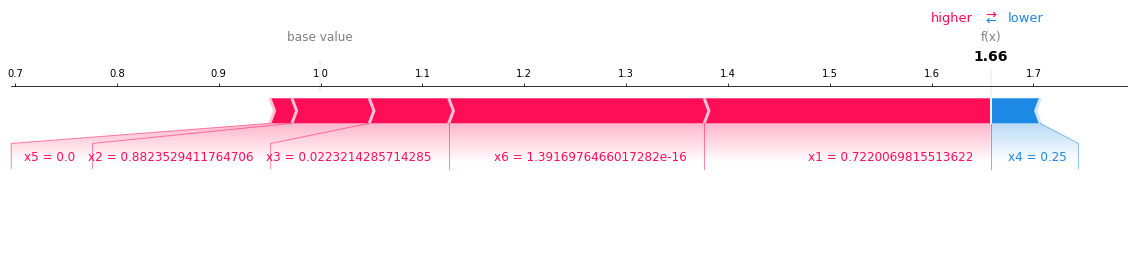

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[1][1,:], X_test.iloc[1,:], link="identity", matplotlib=True)

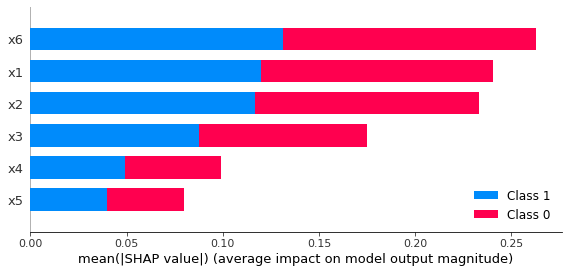

In [ ]:
shap.summary_plot(shap_values, X_test[:1000], plot_type="bar")

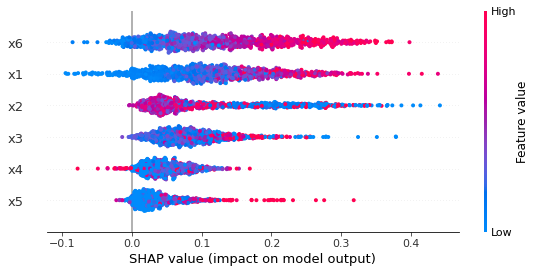

In [ ]:
shap.summary_plot(shap_values[1], X_test[:1000], plot_type="dot")

# Summary

In [ ]:
hidden_dir = "/content/gdrive/MyDrive/Text Mining/Hidden/inputs/"
labels_hidden_dir = "/content/gdrive/MyDrive/Text Mining/Hidden/labels/"
filenames_hidden = [hidden_dir + filename for filename in os.listdir(hidden_dir)]
labels_filenames_train = [labels_hidden_dir + filename for filename in os.listdir(labels_hidden_dir)]

In [ ]:
hidden = data_loader(filenames_hidden, labels_hidden_dir)

In [ ]:
doc = dict()
doc['id'] = hidden['id'][0:90]
doc['documents'] = hidden['documents'][0:90]
doc['labels'] = hidden['labels'][0:90]

In [ ]:
summaries = dict()
summaries['id'] = []
summaries['summary'] = []

In [ ]:
processed_doc = preprocess(doc)

In [ ]:
for index_doc, document in enumerate(processed_doc['documents']):
  doc = dict()
  doc['documents'] = processed_doc['documents'][index_doc:index_doc+1]
  x1_vector_doc = get_x1(doc)
  x2_vector_doc = get_x2(doc)
  x3_vector_doc = get_x3(doc)
  x4_vector_doc, x5_vector_doc = get_x4_x5(doc)
  x6_vector_doc = get_x6(doc)
  labels_doc = get_labels_feature_extraction(doc)
  df_hidden = pd.DataFrame()
  df_hidden['x1'] = x1_vector_doc
  df_hidden['x2'] = x2_vector_doc
  df_hidden['x3'] = x3_vector_doc
  df_hidden['x4'] = x4_vector_doc
  df_hidden['x5'] = x5_vector_doc
  df_hidden['x6'] = x6_vector_doc
  probabilities = rf.predict_proba(df_hidden)
  sentence_selection = df_hidden
  sentence_selection['prob_0'] = probabilities[:,0]
  sentence_selection['prob_1'] = probabilities[:,1]
  tokens_count = []
  for sentence in document['sentences']:
    n_tokens = len(sentence['tokens'])
    tokens_count.append(n_tokens)
  sentence_selection['tokens_count'] = tokens_count
  sentence_selection.sort_values(by='prob_1', ascending=False, inplace=True)
  max_tokens = 200
  count_tokens = 0
  index_summary = []
  for index, sentence in sentence_selection.iterrows():
    if count_tokens + sentence['tokens_count'] <= max_tokens:
      index_summary.append(index)
      count_tokens += sentence['tokens_count']
    else:
      break
  
  summary = ''
  for i in index_summary:
    summary = summary + '' + hidden['documents'][index_doc][1][i]['text']
  summaries['id'].append(hidden['documents'][index_doc][0])
  summaries['summary'].append(summary)

In [ ]:
def get_ref_summary(filename):
  with open(filename, "r") as f:
        abstract = f.read()
  return abstract

In [ ]:
abstract_dir = '/content/gdrive/MyDrive/Text Mining/Hidden/human-abstracts/'
filenames_abstract = [abstract_dir + filename for filename in os.listdir(abstract_dir)]

In [ ]:
summary_ref = []
for filename in filenames_abstract[0:90]:
  summary = get_ref_summary(filename)
  summary_ref.append(summary)

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(summaries['summary'], summary_ref, avg=True)

In [ ]:
scores

{'rouge-1': {'r': 0.4235344976640247,
  'p': 0.3249843602409613,
  'f': 0.3497492699597597},
 'rouge-2': {'r': 0.1791863778392344,
  'p': 0.12627206857908974,
  'f': 0.13855247604318377},
 'rouge-l': {'r': 0.38148551898924504,
  'p': 0.29326675672356145,
  'f': 0.3153311501079932}}

In [ ]:
summaries['summary'][30]

'another study conducted by beahrs et al . , which involved more than 8000 abdominal ct scans performed on patients with normal - sized intact spleen was able to observe no accessory spleen larger than 2.5  cm .as previously mentioned , the accessory spleen discovered in our patient measured 2.5    2.0    0.7  cm .our patient presented for an lsg , where the incidental accessory spleen was incidentally discovered on the fundus of the stomach .the patient underwent her laparoscopic sleeve gastrectomy in august 2015 , but during the initial visualization of the abdominal cavity , a large accessory spleen was found , measuring 2.5    2.0    0.7  cm on the gastric fundus ( fig .a possible explanation for the existence of larger accessory spleens is that , in patients that have undergone a previous splenectomy , accessory spleens tend to undergo compensatory hypertrophy , sometimes reaching 35  cm in size , however , this was not the case in our patient , as she had not undergone a splenect